## Lorenz 96 model
- Lorenz EN (1996) Predictability: A problem partly solved. Proc ECMWF Seminar on Predictability (European Centre for Medium-Range Weather Forecasts, Shinfield Park, Reading, Berkshire, UK), Vol 1, pp 1–18.
- Fatkulin I, Vanden-Eijnden E (2004) A computational strategy for multi-scale systems with applications to Lorenz’96 model. J Comput Phys 200(2):605–638.
- Crommelin D, Vanden-Eijnden E (2008) Subgrid-scale parameterization with conditional Markov chains. J Atmos Sci 65(8):2661–2675.
- Chorin AJ, Lu F (2015) Discrete approach to stochastic parametrization and dimension reduction in nonlinear dynamics. PNAS 112(32):9804-9809.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from time import time as timer
        
eps = 0.5 # Time scale for unresolved y
K = 18    # Number of resolved x
J = 20    # Additional dimension of unresolved y
F = 10    # Constant forcing
hx = -1   # y->x coupling
hy = 1    # x->y coupling

tsta = 0      # Start time
tend = 200   # End time
dt_out = 0.01 # Time step size

def L96xy(t, var, eps, K, J, F, hx, hy):
    """Lorenz 96 model with constant forcing to model resolved dynamics x and unresolved dynamics y"""
    x = var[0:K]
    y = var[K:].reshape(K,J)
    z = (hx/J)*np.sum(y,axis=1)
    dxdt = np.roll(x,1)*(np.roll(x,-1)-np.roll(x,2))-x+F+z
    dydt = (1/eps)*(np.roll(y,-1)*(np.roll(y,1)-np.roll(y,-2))-y+hy*x.reshape(K,1))
    dvardt = np.concatenate([dxdt,dydt.ravel()])
    return dvardt

# Set initial values
x_equilibrium = F/(1-hx*hy)
y_equilibrium = hy * x_equilibrium
x = x_equilibrium*np.ones(K)
y = y_equilibrium*np.ones(K*J)
init_var = np.concatenate([x,y])
init_var[0] = init_var[0]*1.01 # Small perturbation is added
print("x_eqiulibirum=",x_equilibrium,", y_equilibirum=",y_equilibrium)

# Solve inivial value problem 
t1=timer()
t_span = [tsta, tend]
sol = solve_ivp(L96xy, t_span=t_span, y0=init_var, method="RK45",
                args=[eps, K, J, F, hx, hy], dense_output=True)
t = np.arange(t_span[0], t_span[1], dt_out)
var = sol.sol(t)
ntime = var.shape[1]
x = var[0:K,:]
y = var[K:,:].reshape(K,J,ntime)
t2=timer();print("Elapsed time=",t2-t1)

x_eqiulibirum= 5.0 , y_equilibirum= 5.0
Elapsed time= 3.0832455158233643


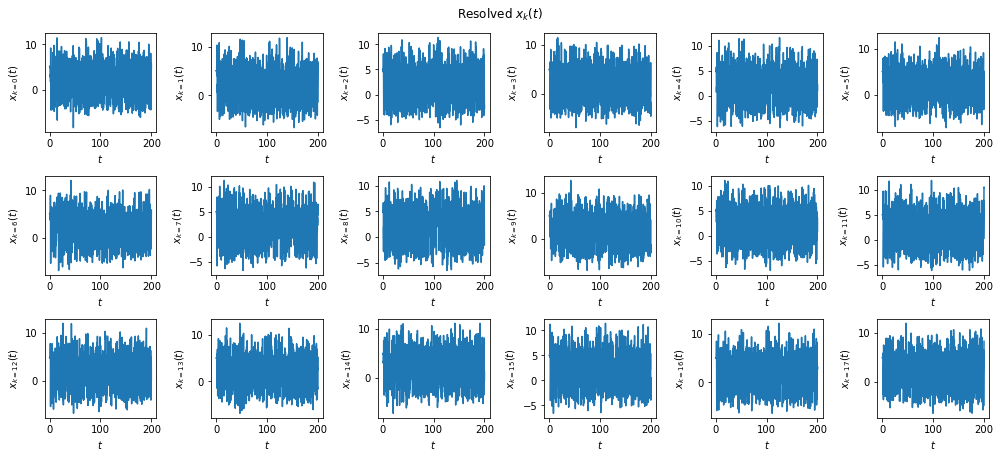

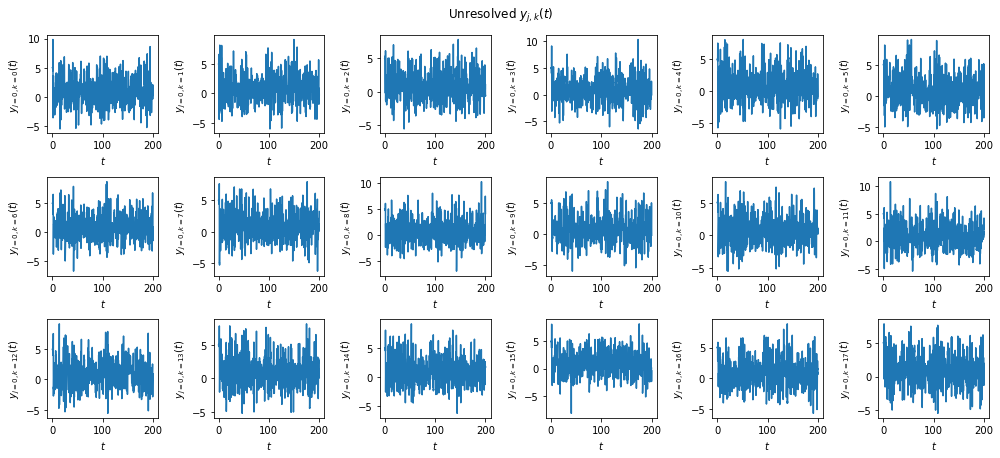

In [2]:
fig = plt.figure(figsize=(14,8))
ncol=6
for k in range(K):
    ax = plt.subplot2grid((int(K/ncol)+1,ncol), (int(k/ncol),k%ncol))
    ax.plot(t,x[k,:])
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$x_{k="+r"{:d}".format(k)+r"}(t)$")
fig.suptitle("Resolved $x_k(t)$")
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(14,8))
for k in range(K):
    ax = plt.subplot2grid((int(K/ncol)+1,ncol), (int(k/ncol),k%ncol))
    ax.plot(t,y[k,0,:])
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$y_{j=0,k="+r"{:d}".format(k)+r"}(t)$")
fig.suptitle("Unresolved $y_{j,k}(t)$")
fig.tight_layout()
plt.show()

# Check normalization of PDF 0.9999999999999999


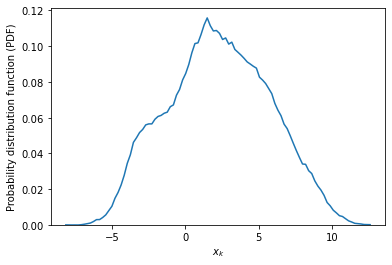

In [3]:
d = x[:,100:].ravel()
x_hist, bins = np.histogram(d,bins=100)
x_range = (bins[:-1] + bins[1:])/2
bin_width = bins[1]-bins[0]
pdf = x_hist / d.size / bin_width
print("# Check normalization of PDF", np.sum(pdf)*bin_width)

fig = plt.figure()
ax=fig.add_subplot(111)
# ax.hist(d,bins=50)
ax.plot(x_range,pdf)
ax.set_xlabel("$x_k$")
ax.set_ylabel("Probability distribution function (PDF)")
ax.set_ylim(0,None)
plt.show()

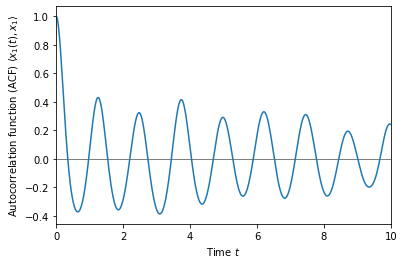

In [4]:
d = x[0,100:]
d = d - np.average(d)
acf = np.correlate(d,d,mode="full")[len(d)-1:]
acf = acf / acf[0]

tplot=10
nplot=int(tplot/dt_out)
fig = plt.figure()
ax=fig.add_subplot(111)
ax.axhline(0,lw=0.5,c="k")
ax.plot(t[:nplot],acf[:nplot])
ax.set_xlabel(r"Time $t$")
ax.set_ylabel(r"Autocorrelation function (ACF) $\langle x_1(t),x_1 \rangle$")
ax.set_xlim(0,tplot)
plt.show()

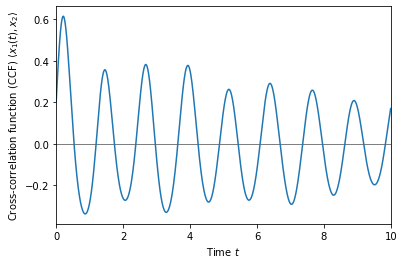

In [5]:
d1 = x[0,100:]
d1 = d1 - np.average(d1)
d2 = x[1,100:]
d2 = d2 - np.average(d2)
ccf = np.correlate(d1,d2,mode="full")[len(d1)-1:]
ccf = ccf / np.sqrt(np.sum(d1*d1)*np.sum(d2*d2))

tplot=10
nplot=int(tplot/dt_out)
fig = plt.figure()
ax=fig.add_subplot(111)
ax.axhline(0,lw=0.5,c="k")
ax.plot(t[:nplot],ccf[:nplot])
ax.set_xlabel(r"Time $t$")
ax.set_ylabel(r"Cross-correlation function (CCF) $\langle x_1(t),x_2 \rangle$")
ax.set_xlim(0,tplot)
plt.show()

In [6]:
### Output for multivariate Mori-Zwanzig projection
import xarray as xr
z = (hx/J)*np.sum(y,axis=1)
dxdt = np.roll(x,1,axis=0)*(np.roll(x,-1,axis=0)-np.roll(x,2,axis=0))-x+F+z

u = x
dudt = dxdt
f = z

xr_u = xr.DataArray(u,dims=("k","t"),coords={"k":np.arange(K),"t":t})
xr_dudt = xr.DataArray(dudt,dims=("k","t"),coords={"k":np.arange(K),"t":t})
xr_f = xr.DataArray(f,dims=("k","t"),coords={"k":np.arange(K),"t":t})

ds = xr.Dataset({"u":xr_u,"dudt":xr_dudt,"f":xr_f})
ds.to_netcdf("sample_multivariate_L96xy.nc")
print(ds)

<xarray.Dataset>
Dimensions:  (k: 18, t: 20000)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
  * t        (t) float64 0.0 0.01 0.02 0.03 0.04 ... 200.0 200.0 200.0 200.0
Data variables:
    u        (k, t) float64 5.05 5.049 5.049 5.048 ... 7.911 8.061 8.2 8.327
    dudt     (k, t) float64 -0.05 -0.05131 -0.05426 ... 14.5 13.31 11.96
    f        (k, t) float64 -5.0 -5.001 -5.002 -5.003 ... -2.231 -2.343 -2.455
